# **Scripts and outputs for training, calibrating, and perform cross-validation and empirical data prediction for the species *Euphorbia segueriana*** (scripts for the remaining species are similar).
From the manuscript Kirschner & Perez et al. "Congruent evolutionary responses of European steppe biota to late Quaternary climate change: insights from convolutional neural network-based demographic modeling".

In [ ]:
# Import all required modules.
import sys, os
import numpy as np
import time
import random
from random import shuffle, choice
import keras
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.constraints import max_norm
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import backend as K
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.models import load_model
from keras.utils import np_utils
from sklearn.calibration import CalibratedClassifierCV
from sklearn.calibration import calibration_curve
import sklearn.metrics as metrics
from sklearn.metrics import log_loss
from sklearn.metrics import confusion_matrix

# Define parameters for the CNN run.
batch_size = 500
epochs = 500
num_classes = 3

# Define the CNN architecture.
def create_cnn(xtest):
	#use different filter sizes.
	filters = [3,5,20,50]
	inputShape = (xtest.shape[1], xtest.shape[2])
	inputs = Input(shape=inputShape)
	x = inputs
	x = Conv1D(250, kernel_size=2, activation='relu',input_shape=(xtest.shape[1], xtest.shape[2]))(x)
	x = BatchNormalization()(x)
	for f in range(len(filters)):
		x = Conv1D(20, kernel_size=filters[f], activation='relu',kernel_constraint=max_norm(3), bias_constraint=max_norm(3))(x)
		x = BatchNormalization()(x)
	x = Conv1D(125, kernel_size=2, activation='relu',kernel_constraint=max_norm(3), bias_constraint=max_norm(3))(x)
	x = BatchNormalization()(x)
	x = Conv1D(125, kernel_size=2, activation='relu',kernel_constraint=max_norm(3), bias_constraint=max_norm(3))(x)
	x = AveragePooling1D(pool_size=2)(x)
	x = Flatten()(x)
	x = Dense(125, activation='relu',kernel_regularizer=l2(1e-3), bias_regularizer=l2(1e-3))(x)
	x = Dropout(0.5)(x)
	x = Dense(125, activation='relu',kernel_regularizer=l2(1e-3), bias_regularizer=l2(1e-3))(x)
	x = Dropout(0.5)(x)
	# Before the last layer, save a layer with logits, which will help in calibration
	logits = Dense(num_classes, name='logits')(x)
	# The final fully-connected layer head will have a softmax dense layer.
	out = Activation('softmax')(logits)

	# Construct the CNN.
	model = Model(inputs, out)
	# Return the CNN.
	return model

## **Define functions**

In [ ]:
def fit_TemperatureCalibration(train_X_y, valid_X_y=None, epochs=100):
    ''' From: https://github.com/cerlymarco/MEDIUM_NoteBook/blob/master/NeuralNet_Calibration/NeuralNet_Calibration.ipynb; inspired by: https://github.com/stellargraph/stellargraph/blob/develop/stellargraph/calibration.py 
    Performs temperature scaling'''
    
    T = tf.Variable(tf.ones(shape=(1,)), name="T")
    history = []
    early_stopping = False
    optimizer = Adam(learning_rate=0.001)
    
    def cost(T, x, y):

        scaled_logits = tf.multiply(x=x, y=1.0 / T)

        cost_value = tf.reduce_mean(
            tf.nn.softmax_cross_entropy_with_logits(logits=scaled_logits, labels=y)
        )

        return cost_value

    def grad(T, x, y):

        with tf.GradientTape() as tape:
            cost_value = cost(T, x, y)

        return cost_value, tape.gradient(cost_value, T)
    
    
    X_train, y_train = train_X_y
    if valid_X_y:
        X_valid, y_valid = valid_X_y
        early_stopping = True
    
    
    for epoch in range(epochs):
        train_cost, grads = grad(T, X_train, y_train)
        optimizer.apply_gradients(zip([grads], [T]))
        if early_stopping:
            val_cost = cost(T, X_valid, y_valid)
            if (len(history) > 0) and (val_cost > history[-1][1]):
                break
            else: 
                history.append([train_cost, val_cost, T.numpy()[0]])
        else:
            history.append([train_cost, T.numpy()[0]])

    history = np.asarray(history)
    temperature = history[-1, -1]
    
    return temperature

def cal_softmax(x):
    """
    From: https://github.com/markus93/NN_calibration
    Compute softmax values for each sets of scores in x.
    
    Parameters:
        x (numpy.ndarray): array containing m samples with n-dimensions (m,n)
    Returns:
        x_softmax (numpy.ndarray) softmaxed values for initial (m,n) array
    """
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=1, keepdims=1)

def evaluate(probs, y_true, verbose = False, normalize = False):
    """
    Modified from: https://github.com/markus93/NN_calibration
    Evaluate model using Error Rate and loss
    
    Params:
        probs: a list containing probabilities for all the classes with a shape of (samples, classes)
        y_true: a list containing the actual class labels
        verbose: (bool) are the scores printed out. (default = False)
        normalize: (bool) in case of 1-vs-K calibration, the probabilities need to be normalized.
        
    Returns:
        (error, loss), returns various scoring measures
    """
    
    preds = np.argmax(probs, axis=1)  # Take maximum confidence as prediction
    
    if normalize:
        confs = np.max(probs, axis=1)/np.sum(probs, axis=1)
        # Check if everything below or equal to 1?
    else:
        confs = np.max(probs, axis=1)  # Take only maximum confidence
    
    accuracy = metrics.accuracy_score(y_true, preds) * 100
    error = 100 - accuracy
        
    loss = log_loss(y_true=y_true, y_pred=probs)
        
    if verbose:
        print("Accuracy:", accuracy)
        print("Error:", error)
        print("Loss:", loss)
    
    return (error, loss)

## **Train the network with 10,000 simulations from each model**
Use the simulated dataset to train the network, by splitting the data with 75% of simulations for training and 25% for validation.

In [ ]:
# Load Numpy arrays containing simulations.
u1 = np.load("./trainingSims/simModel1.npy",mmap_mode='r')
u2 = np.load("./trainingSims/simModel2.npy",mmap_mode='r')
u3 = np.load("./trainingSims/simModel3.npy",mmap_mode='r')

# Combine all arrays.
x=np.concatenate((u1,u2,u3),axis=0)

# Label each simulated array.
y=[0 for i in range(len(u1))]
y.extend([1 for i in range(len(u2))])
y.extend([2 for i in range(len(u3))])
y = np.array(y)

#delete temporary files to free memory.
del (u1,u2,u3)

# Print label and simulations length, these should be the same.
print (len(x), len(y))

# Shuffle the arrays for training, keeping the labels in the same order.
shf = list(range(len(x)))
shuffle(shf)
y = y[shf]
x = x[shf]

# Convert the reference allele to -1.
x[x == 0] = -1

#Add missing data (coded as 0s) to the simulated matrices (with a percentage according to the empirical data - 15% in E. segueriana).
missD = int(x.shape[1]*x.shape[2]*.15)
for i in range(x.shape[0]):
  for m in range(missD):
    j = random.randint(0, x.shape[1] - 1)
    k = random.randint(0, x.shape[2] - 1)
    x[i][j][k] = 0
del(missD)

# Separate train (75%) and validate (25%) sets.
xtrain, xtest = x[int(len(y)*.25):], x[:int(len(y)*.25)]
ytrain, ytest = y[int(len(y)*.25):], y[:int(len(y)*.25)]
del(x)
ytest = keras.utils.to_categorical(ytest, num_classes)
ytrain = keras.utils.to_categorical(ytrain, num_classes)

# Create the CNN network.
model = create_cnn(xtest)

# Compile the CNN.
model.compile(loss=keras.losses.categorical_crossentropy,
	              optimizer='Adam',
	              metrics=['accuracy'])

# Check the architecture.
model.summary()

# Run the CNN with early stopping and reducing the learning rate after reaching a plateau. Save the model with the best val_accuracy.
earlyStopping = EarlyStopping(monitor='val_accuracy', patience=100, verbose=0, mode='max', restore_best_weights=True)
reduce_lr_loss = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=20, verbose=1, mode='max')

model.fit(xtrain, ytrain, batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(xtest, ytest))

# Save the model.
model.save(filepath='./trainingSims/Trained_uncalibrated_91315_Esegueriana._MissingData.acc.mod')

70000 70000
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 195, 64)]         0         
_________________________________________________________________
conv1d (Conv1D)              (None, 194, 250)          32250     
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 193, 125)          62625     
_________________________________________________________________
average_pooling1d (AveragePo (None, 96, 125)           0         
_________________________________________________________________
dropout (Dropout)            (None, 96, 125)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 95, 125)           31375     
_________________________________________________________________
average_pooling1d_1 (Average (None, 47, 125)     

## **Use temperature scaling to calibrate the trained CNN with 5,000 simulations per model and perform cross validation predictions with another 5,000 simulations.**

In [ ]:

# Load Numpy test set arrays containing the test set simulations.
u1 = np.load("./testSims/simModel1.npy",mmap_mode='r')
u2 = np.load("./testSims/simModel2.npy",mmap_mode='r')
u3 = np.load("./testSims/simModel3.npy",mmap_mode='r')

# Separate 5,000 simulations for calibration and the remaining 5,000 for cross-validation predictions.
xcal=np.concatenate((u1[0:5000,:,:],u2[0:5000,:,:],u3[0:5000,:,:]),axis=0)
xpred=np.concatenate((u1[5000:10000,:,],u2[5000:10000,:,:],u3[5000:10000,:,:]),axis=0)

# Label each simulated array.
y=[0 for i in range(len(u1[0:5000,:,:]))]
y.extend([1 for i in range(len(u2[0:5000,:,:]))])
y.extend([2 for i in range(len(u3[0:5000,:,:]))])

y = np.array(y)

#delete temporary files to free memory.
del (u1,u2,u3)

# Print label and simulations length, these should be the same.
print (len(xcal), len(xpred), len(y))

# Shuffle the arrays for training, keeping the labels in the same order.
shf = list(range(len(xcal)))
shuffle(shf)
y_shf = y[shf]
xcal = xcal[shf]

# Convert the reference allele to -1.
xcal[xcal == 0] = -1
xpred[xpred == 0] = -1

#Add missing data (coded as 0s) to the simulated matrices (with a percentage according to the empirical data - 15% in E. segueriana).
missD = int(xcal.shape[1]*xcal.shape[2]*.15)
for i in range(xcal.shape[0]):
  for m in range(missD):
    j = random.randint(0, xcal.shape[1] - 1)
    k = random.randint(0, xcal.shape[2] - 1)
    xcal[i][j][k] = 0
del(missD)

missD = int(xpred.shape[1]*xpred.shape[2]*.15)
for i in range(xpred.shape[0]):
  for m in range(missD):
    j = random.randint(0, xpred.shape[1] - 1)
    k = random.randint(0, xpred.shape[2] - 1)
    xpred[i][j][k] = 0
del(missD)

# Split the calibration simulations, 50% for training and 50% for validation.
xtrain, xtest = xcal[int(len(y)*.5):], xcal[:int(len(y)*.5)]
ytrain, ytest = y_shf[int(len(y_shf)*.5):], y_shf[:int(len(y_shf)*.5)]

ytest = np_utils.to_categorical(ytest, num_classes)
ytrain = np_utils.to_categorical(ytrain, num_classes)

#Calibrate the model.
model_score = Model(inputs=model.input, outputs=model.get_layer('logits').output)
X_train_calib = model_score.predict(xtrain)
X_valid_calib = model_score.predict(xtest)
temperature = fit_TemperatureCalibration((X_train_calib,ytrain), (X_valid_calib,ytest), epochs=100)
print ("Temperature",temperature)

# Evaluate error and loss for the uncalibrated and calibrated CNN models.
pred = model.predict(xpred)
pred_cal = model_score.predict(xpred)
scaled_prediction = cal_softmax(pred_cal/temperature)
print("Uncalibrated Error %f; loss %f" % evaluate(pred, y, verbose=False, normalize=True))
print("Calibated Error %f; loss %f" % evaluate(scaled_prediction, y, verbose=False, normalize=True))

# Predict with the calibrated model and export a confusion matrix.
pred_cat = [i.argmax() for i in scaled_prediction]
print (confusion_matrix(y, pred_cat))
print (confusion_matrix(y, pred_cat) / float(len(y)))

# Save the 5,000 predictions per model from the test set, to be used as Summary Statistics in ABC.
np.savetxt("testSet_CalibratedModelPredictions.txt", scaled_prediction)

[[876   0  18   0   0 106   0]
 [  2 824   0   9   5   0 160]
 [  0   0 998   2   0   0   0]
 [  0   1  46 929  23   0   1]
 [  0   1   0   1 997   0   1]
 [ 48   0  18   0   0 934   0]
 [  0  22   2  16   4   1 955]]


## **Predict the most likely model for the empirical data, using the calibrated CNN.**

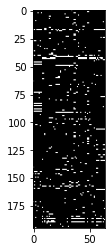

In [ ]:
# Load empirical data.
infile=np.loadtxt("../input_Esegueriana.txt")
inp=np.array(infile)

# Create 100 subsets containing 1,000 random SNPs from the full empirical data.
num_samples=100
res = []
for i in range(0,num_samples):
	idx = np.random.choice(inp.shape[0], 1000, replace=False)
	n = inp[idx,:]
	res.append(np.array(n))

Emp = np.array(res)

# Predict model probabilities.
Emp_pred = model_score.predict(Emp)
Emp_pred = cal_softmax(Emp_pred/temperature)

np.savetxt("Emp_ModelPredictions.txt", Emp_pred)